In [1]:
import bcolz
import numpy as np
import os
import glob
import threading
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor 
from PIL import Image
from vgg16 import Vgg16
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Using TensorFlow backend.


We will resize our images to 224 x 224

In [2]:
new_size = 224
# rootdir = os.getcwd()
# DANGER DANGER DANGER
# THIS WILL COMPLETELY EMPTY YOUR DIRECTORY TO MAKE ITS OWN FOLDERS
# KILLED MY TRAINING DATA AND DELETED MY JUPYTER NOTEBOOK
rootdir = '/home/drsnuggles/bcolz/data'
arr = bcolz.carray(np.empty((0, new_size, new_size, 3), 'float32'), 
                   chunklen=16, mode='w', rootdir=rootdir)

# chunklen: the default size of the block that is returned from rootdir's data. 
#           the higher the faster, but the more memory it uses


In [3]:
arr

carray((0, 224, 224, 3), float32)
  nbytes := 0; cbytes := 9.19 MB; ratio: 0.00
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 0
  rootdir := '/home/drsnuggles/bcolz/data'
  mode    := 'w'
[]

In [4]:
np.empty((0, new_size, new_size, 3), 'float32')

array([], shape=(0, 224, 224, 3), dtype=float32)

In [5]:
%%bash
tree /home/drsnuggles/bcolz/data

/home/drsnuggles/bcolz/data
├── __attrs__
├── data
└── meta
    ├── sizes
    └── storage

2 directories, 3 files


In [6]:
tl = threading.local()
#A class that represents thread-local data. Thread-local data are data whose values are thread specific.

tl.place = np.zeros((new_size,new_size,3), 'uint8')
tl.place.shape

(224, 224, 3)

In [7]:


def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    
    if len(s)!=3 or s[2]!=3: return

    shortest = min(img.width,img.height)
    
    resized = np.round(np.multiply(new_size/shortest, img.size)).astype(int)    
    return img.resize(resized, Image.BILINEAR)


def get_slice(p, n):
    return slice( (p-n+1)//2, p-(p-n)//2 )

def app_img(r):
    """ Replaces our temporary all-zeroes array with slices of the actual data
    if no data, put 0. in there"""
    # it's necessary to make temporary sub arrays so we can run separate jobs at once
    
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_size), get_slice(r.size[0],new_size)] if r else 0.)
    # append to our big array, i think this locks the array
    arr.append(tl.place)
    


Now load some training data

In [8]:
#fnames = glob.glob('/home/drsnuggles/bcolz/train/*/*.jpg')
fnames = glob.glob('/home/drsnuggles/bcolz/train/full/*jpg')

In [9]:
fnames[0]

'/home/drsnuggles/bcolz/train/full/dog.12144.jpg'

In [10]:
n = len(fnames)
n

25000

In [11]:
# Parallel version
step=6400

# tqdm is just there to make a status bar
for i in tqdm(range(0, n, step)):

    with ThreadPoolExecutor(max_workers=12) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res:
            app_img(r)
    arr.flush()


100%|██████████| 4/4 [01:13<00:00, 17.73s/it]


so 1:10 minutes to load 25,000 pictures

In [12]:
arr

carray((25000, 224, 224, 3), float32)
  nbytes := 14.02 GB; cbytes := 3.89 GB; ratio: 3.60
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 32768
  rootdir := '/home/drsnuggles/bcolz/data'
  mode    := 'w'
[[[[ 203.  203.  191.]
   [ 200.  201.  184.]
   [ 199.  200.  184.]
   ..., 
   [   7.    7.    5.]
   [   5.    5.    3.]
   [   6.    6.    4.]]

  [[ 217.  218.  207.]
   [ 221.  223.  209.]
   [ 220.  222.  208.]
   ..., 
   [   6.    6.    4.]
   [   5.    5.    3.]
   [   6.    6.    4.]]

  [[ 236.  238.  229.]
   [ 235.  238.  227.]
   [ 230.  234.  223.]
   ..., 
   [   5.    5.    3.]
   [   6.    6.    4.]
   [   5.    5.    3.]]

  ..., 
  [[  72.   62.   55.]
   [  72.   62.   54.]
   [  67.   59.   53.]
   ..., 
   [  32.   17.   13.]
   [  32.   17.   12.]
   [  33.   18.   12.]]

  [[  70.   60.   53.]
   [  72.   62.   54.]
   [  70.   62.   56.]
   ..., 
   [  33.   18.   14.]
   [  33.   18.   13.]

In [13]:
# automatically saved - let's open again!
arr = bcolz.open('/home/drsnuggles/bcolz/data/')

In [14]:
arr

carray((25000, 224, 224, 3), float32)
  nbytes := 14.02 GB; cbytes := 3.89 GB; ratio: 3.60
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 32768
  rootdir := '/home/drsnuggles/bcolz/data/'
  mode    := 'a'
[[[[ 203.  203.  191.]
   [ 200.  201.  184.]
   [ 199.  200.  184.]
   ..., 
   [   7.    7.    5.]
   [   5.    5.    3.]
   [   6.    6.    4.]]

  [[ 217.  218.  207.]
   [ 221.  223.  209.]
   [ 220.  222.  208.]
   ..., 
   [   6.    6.    4.]
   [   5.    5.    3.]
   [   6.    6.    4.]]

  [[ 236.  238.  229.]
   [ 235.  238.  227.]
   [ 230.  234.  223.]
   ..., 
   [   5.    5.    3.]
   [   6.    6.    4.]
   [   5.    5.    3.]]

  ..., 
  [[  72.   62.   55.]
   [  72.   62.   54.]
   [  67.   59.   53.]
   ..., 
   [  32.   17.   13.]
   [  32.   17.   12.]
   [  33.   18.   12.]]

  [[  70.   60.   53.]
   [  72.   62.   54.]
   [  70.   62.   56.]
   ..., 
   [  33.   18.   14.]
   [  33.   18.   13.

In [29]:
%%bash
echo "Size bcolz"
du -sh /home/drsnuggles/bcolz/data/
echo "Size raw data"
du -sh /home/drsnuggles/bcolz/train/full/

Size bcolz
3.9G	/home/drsnuggles/bcolz/data/
Size raw data
595M	/home/drsnuggles/bcolz/train/full/


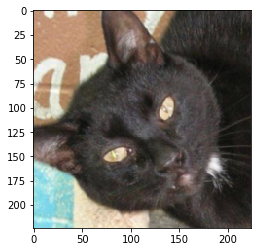

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(arr[-1].astype('uint8'))

ねこ！

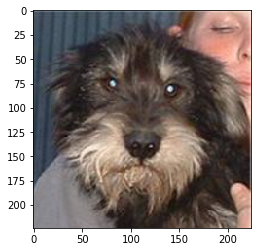

In [17]:
plt.imshow(arr[-2].astype('uint8'))

doggo!

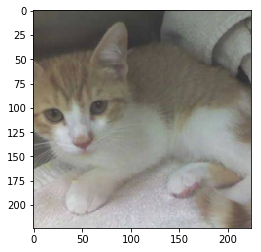

In [18]:
plt.imshow(arr[-100].astype('uint8'))

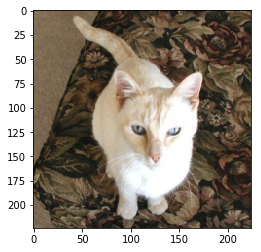

In [19]:
plt.imshow(arr[99].astype('uint8'))

How is this stuff drawn again?

In [20]:
print('Pixel 0x0 has these colors:', arr[99][0][0])

Pixel 0x0 has these colors: [ 133.  116.   90.]


Now we need to make some labels, either from the filenames or from the order in the array. let's be lazy. Need a 2 dimensional array of length 200, 1 means cat, 0 means dog

In [21]:
# make a zeros-filles numpy array in my wanted dimensions, then overwrite the entries with the actual label
labels = np.zeros((n, 2))
print(labels[:2])
for counter, l in enumerate(fnames):
    if 'dog' in l:
        labels[counter] = [0,1]
    else:
        labels[counter] = [1,0]
        
print(labels[:2])
print(fnames[:2])

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  1.]
 [ 1.  0.]]
['/home/drsnuggles/bcolz/train/full/dog.12144.jpg', '/home/drsnuggles/bcolz/train/full/cat.4993.jpg']


In [22]:
vgg = Vgg16()

In [23]:
imgs = arr[:4]
imgs.shape

(4, 224, 224, 3)

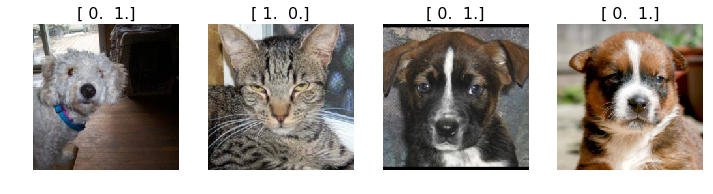

In [24]:
plots(imgs, titles=labels[:4])

Annoyance: this vgg16 implementation wants the shape to be (4, 3, 224, 224)

In [25]:
imgs = np.swapaxes(imgs, 1, 3)

Let's predict some cats!

In [26]:
vgg.predict(imgs, True)

(array([ 0.36215425,  0.57914436,  0.2267835 ,  0.81014997], dtype=float32),
 array([265, 285, 225, 387]),
 ['toy_poodle', 'Egyptian_cat', 'malinois', 'lesser_panda'])


    preds (np.array) : Highest confidence value of the predictions for each image.
    idxs (np.ndarray): Class index of the predictions with the max confidence.
    classes (list)   : Class labels of the predictions with the max confidence.


Let's predict some dogs!

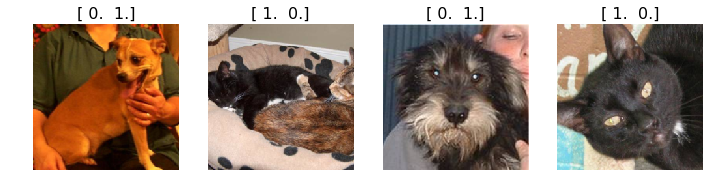

In [27]:
imgs = arr[-4:]
plots(imgs, titles=labels[-4:])

In [28]:

imgs = np.swapaxes(imgs, 1, 3)
vgg.predict(imgs, True)

(array([ 0.25085124,  0.12603666,  0.21951129,  0.47075069], dtype=float32),
 array([171, 242, 192, 223]),
 ['Italian_greyhound', 'boxer', 'cairn', 'schipperke'])